In [1877]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from typing import Union, List

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from preprocessing import *
from feature_engineering import *



In [1878]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2249]:
listings_raw = pd.read_csv("../data/raw/munich/2020-06-20/listings.csv.gz",compression="gzip")
#listings_raw = pd.read_csv("../data/raw/munich/2019-11-25/listings.csv.gz",compression="gzip")

listings_raw.shape

(11172, 106)

In [2250]:
listings = listings_raw.copy()

In [2251]:
# Mietspiegel Preise 2020 : https://www.wohnungsboerse.net/mietspiegel-Muenchen/2091
#del listings


In [2252]:
# Format price
listings["price"] = format_price(listings["price"])
listings["cleaning_fee"] = format_price(listings["cleaning_fee"])
listings["cleaning_fee"] = listings["cleaning_fee"].fillna(0)
listings["extra_people"] = format_price(listings["extra_people"])

In [2253]:


# Drop outliers
def drop_outliers(listings, min_quantile=0.01, max_quantile=0.995):
    listings = listings[listings["price"] < listings["price"].quantile(max_quantile)]
    listings = listings[listings["price"] > listings["price"].quantile(min_quantile)]
    return listings

listings = drop_outliers(listings)

In [2254]:
def text_contains_word(df: pd.DataFrame, search_features: Union[str, List[str]], word: Union[str,List[str]], feature_name: str) -> pd.DataFrame:
    """
    Checks if at least one of the given features contains a given word.

    Input:
    - df: pd.DataFrame
    - search_features: names of columns with text data
    - word: str or list of words to search in the features
    - feature_name: name of new feature

    Returns:
    - pd.DataFrame with a new column named after the given words and representing a true/false flag.
    """
    if isinstance(word, list):
        word = [w.lower() for w in word]
        search_term = "|".join(word) # pipe for "or"-search
    else:
        search_term = word.lower()

    df[search_features] = df[search_features].apply(lambda x: x.str.lower())
    df[feature_name] = df[search_features].apply(lambda x: any(x.str.contains(search_term) & x.notna()), axis=1)
    return df

In [2255]:
def mean_price(df: pd.DataFrame, feature):
    """Get mean price grouped by the given feature."""
    return df.groupby(feature).price.mean(),df.groupby(feature).price.median(), df[feature].value_counts()

In [2256]:
def format_flags(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Format t / f to boolean True and False
    """
    flags = {"t": True, "f": False, "nan": np.NaN}
    for col in columns:
        df[col] = df[col].replace(flags)
        df[col] = df[col].astype(bool)
    return df

In [2257]:
def make_dummies(series: pd.Series, name: str, sep="|") -> pd.DataFrame:
    """
    Performs one-hot encoding and renames the resulting columns by prepending the name parameter to column names
    """
    dummies = series.str.get_dummies(sep=sep)
    dummies.columns = name + dummies.columns
    for col in dummies.columns:
        dummies[col] = dummies[col].astype(bool)
    return dummies

In [2258]:
# Make description-based feature
words = ["roof top", "roof-top", "Dachterasse","Dachterrasse","roof terrace"]
descriptive_columns = ["space", "description"]
listings = text_contains_word(listings, descriptive_columns, words, "roof_top_terrace")
listings["roof_top_terrace"] = listings["roof_top_terrace"].astype(bool)

In [2259]:
# Perform one-hot encoding for amenities
amenities = listings_raw.amenities.str.replace("[{""}]", "")\
                    .str.replace("\"", "")
amenities = make_dummies(amenities, name="amenities_",sep=",")
amenities["total_amount_amenities"] = amenities.sum(axis=1)

# Add (one-hot encoded) amenity features to dataset
listings = pd.concat([listings, amenities], axis=1)


In [2260]:
# Convert host_since to number of month the host is active on AirBnB
listings["host_since_month"] = (pd.Timestamp("2020-07-01") - pd.to_datetime(listings["host_since"])).astype('timedelta64[M]')

In [2261]:
listings = text_contains_word(listings, ["host_location"], ["Munich", "München"], "host_in_munich")


In [2262]:
# since response time is an ordinal feature (the shorter the better) we encode the categories with integers
# unknown is worst -> 5
response_time_encoding = {"within an hour": 1,
                          "within a few hours": 2,
                          "within a day": 3,
                          "a few days or more": 4,
                          "nan": 5}
listings.host_response_time.replace(response_time_encoding, inplace=True)

In [2263]:
# remove %-sign from features containing rates
listings["host_response_rate"] = listings["host_response_rate"].astype(str).str.replace("%","").astype(float)
listings["host_acceptance_rate"] = listings["host_acceptance_rate"].astype(str).str.replace("%","").astype(float)



In [2264]:
listings["host_in_different_neighbourhood"] = listings["host_neighbourhood"] != listings["neighbourhood"]

In [2265]:
neighbourhood_other = listings["host_neighbourhood"].value_counts()[listings["host_neighbourhood"].value_counts()<=20].index
host_neighbourhood = make_dummies(listings["host_neighbourhood"].replace(neighbourhood_other, "other"), name="host_neighbourhood_", sep=" - ")

neighbourhood = make_dummies(listings["neighbourhood"], name="neighbourhood_" , sep=" - ")

listings = pd.concat([listings, host_neighbourhood], axis=1)
listings = pd.concat([listings, neighbourhood], axis=1)

In [2266]:
# Get flag columns and reformat 
flag_cols = listings.apply(lambda x: 'f' in x.dropna().unique() or 't' in x.dropna().unique()).loc[lambda x: x==True].index.values
listings = format_flags(listings, flag_cols)

In [2267]:
# encode host verification
listings["host_verifications"] = listings["host_verifications"].str.replace("\[|\]|'| ","")#.str.get_dummies(sep=",", drop_first=True)#.sum().sort_values()
host_verification_encoding = make_dummies(listings["host_verifications"], name="", sep=",")
# build a group of encoded host verification with just a few samples
other = host_verification_encoding.sum().loc[lambda x: x<100].index.values
host_verification_encoding["other"] = host_verification_encoding[other].any(axis=1)
host_verification_encoding.drop(columns=other, inplace=True)
host_verification_encoding.columns = "host_verification_" + host_verification_encoding.columns#

listings = pd.concat([listings, host_verification_encoding], axis=1)

In [2268]:
listings["property_type"] = listings["property_type"].astype(str)

In [2269]:
# Create "category" for categories that occur seldom. Only make an exception for "villa" since the average price niveau for a "villa" is significantly higher.
other_property_types = listings.loc[listings["property_type"]!="Villa","property_type"].value_counts().loc[lambda x: x < 20].index.values
listings["property_type"] = listings["property_type"].apply(lambda x: "other" if any([p_type in x for p_type in other_property_types]) else x)
property_encoding = make_dummies(listings["property_type"], name="property_type_")
listings = pd.concat([listings, property_encoding], axis=1)


In [2270]:
# use zipcode directly as discrete variable since the codes provide information about how far away one zipcode is from another
listings["zipcode"] = listings["zipcode"].astype(str).str[:5] # make sure that the zipcode contains 5 digits
listings["zipcode"] = listings["zipcode"].astype(float)

In [2271]:
#listings.room_type.value_counts(normalize=True)
room_type = make_dummies(listings["room_type"], name="room_type_")
listings = pd.concat([listings, room_type], axis=1)

In [2272]:
#listings.bed_type.value_counts(normalize=True)
bed_type = make_dummies(listings["bed_type"], name="bed_type_")
listings = pd.concat([listings, bed_type], axis=1)

In [2273]:
#listings.cancellation_policy.value_counts(normalize=True)
cancellation_policy = make_dummies(listings["cancellation_policy"], name="cancellation_policy_")
listings = pd.concat([listings, cancellation_policy], axis=1)

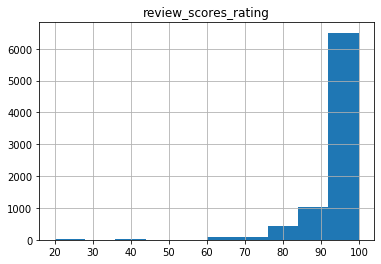

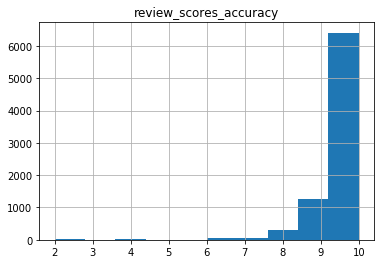

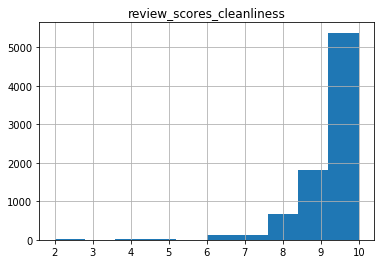

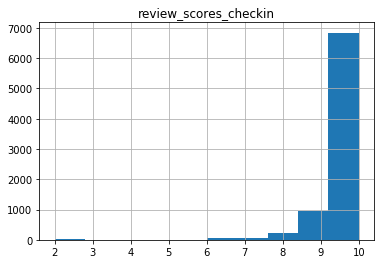

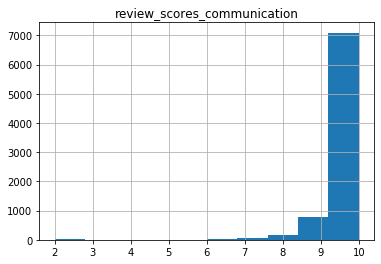

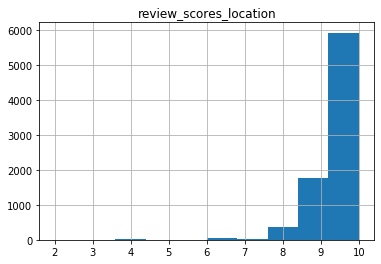

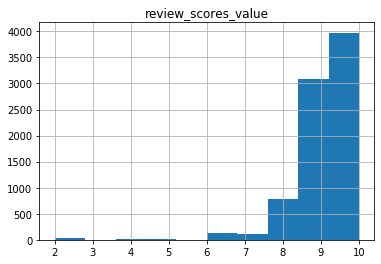

Index(['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')


In [2274]:
for col in listings.columns[listings.columns.str.contains("score")]:
    listings[col].hist()
    plt.title(col)
    plt.show()
print(listings.columns[listings.columns.str.contains("score")])

In [2275]:
#pd.cut(listings["review_scores_accuracy"],bins=[0,8,9,10])


In [2276]:
def make_bins(df, col, bins, labels, one_hot_encoded=False):
    """Bins the series into the given bins. The first bin starts with 0."""
    bins = pd.cut(df[col], bins=bins, include_lowest=True)
    if one_hot_encoded:
        categoricals = pd.get_dummies(bins).astype(bool)
        categoricals.columns = labels
        return categoricals
    return bins

def add_binning_features(listings):
    for col in ['review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value']:
        labels = [col + "_0-8", col + "_9", col + "_10"]
        bins = make_bins(listings, col, bins=[0,8,9,10], labels=labels, one_hot_encoded=True)
        listings = pd.concat([listings, bins], axis=1)

    col = "review_scores_rating"
    labels = [col + "_0-80", col + "_90", col + "_100"]    
    bins = make_bins(listings, col, bins=[0,80,90,100], labels=labels, one_hot_encoded=True)
    listings = pd.concat([listings, bins], axis=1)
    return listings



In [2277]:
listings = add_binning_features(listings)

In [2278]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    See:
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-pointshttps://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def distance_to_point_of_interest(df):
    points_of_interest = {"oktoberfest_geo_location": (48.130910, 11.548901),
    "munich_main_station_geo_location": (48.140283, 11.560488),
    "munich_hofbraeuhaus_geo_location": (48.137612, 11.579911),
    "munich_englischer_garten_geo_location": ( 48.152066, 11.592246 ),
    "munich_deutsches_museum_geo_location": ( 48.129929, 11.583482 )}

    for poi, coords in points_of_interest.items():
        df[poi] = df.apply(lambda x: haversine(x["longitude"], x["latitude"], coords[1], coords[0]), axis=1)

    return df

In [2279]:
listings = distance_to_point_of_interest(listings)

In [2280]:
listings["average_poi_distance"] = listings.apply(lambda x: x[x.index.str.contains("geo_location")].mean(),axis=1)

In [2281]:
listings = listings.dropna(subset=["latitude","longitude"])

In [2282]:
"""
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# k = 57
k_min, k_max = 30, 70
silhouette_scores = []
elbow = []
for k in range(k_min, k_max+1):
    kmeans = KMeans(n_clusters=k)
    result = kmeans.fit_predict(listings[["latitude","longitude"]])
    listings["geo_cluster"] = result

    silhouette_scores.append(silhouette_score(listings[["latitude","longitude"]], kmeans.labels_, metric="euclidean"))
    
    #cmap = plt.get_cmap('gnuplot')
    #colors = [cmap(i) for i in np.linspace(0, 1, k)]
    #for cl, c in zip(listings.geo_cluster.unique(), colors):
    #    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"], color=c)
    #plt.title("k = " + str(k))
    #plt.show()
plt.plot(np.arange(k_min, k_max+1, 1), silhouette_scores)
plt.show()"""

'\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\n# k = 57\nk_min, k_max = 30, 70\nsilhouette_scores = []\nelbow = []\nfor k in range(k_min, k_max+1):\n    kmeans = KMeans(n_clusters=k)\n    result = kmeans.fit_predict(listings[["latitude","longitude"]])\n    listings["geo_cluster"] = result\n\n    silhouette_scores.append(silhouette_score(listings[["latitude","longitude"]], kmeans.labels_, metric="euclidean"))\n    \n    #cmap = plt.get_cmap(\'gnuplot\')\n    #colors = [cmap(i) for i in np.linspace(0, 1, k)]\n    #for cl, c in zip(listings.geo_cluster.unique(), colors):\n    #    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"], color=c)\n    #plt.title("k = " + str(k))\n    #plt.show()\nplt.plot(np.arange(k_min, k_max+1, 1), silhouette_scores)\nplt.show()'

In [2283]:
"""
kmeans = KMeans(n_clusters=57)
result = kmeans.fit_predict(listings[["latitude","longitude"]])
listings["geo_cluster"] = result"""

'\nkmeans = KMeans(n_clusters=57)\nresult = kmeans.fit_predict(listings[["latitude","longitude"]])\nlistings["geo_cluster"] = result'

In [2284]:
"""
from sklearn.cluster import OPTICS
opt = OPTICS(min_samples=8)
result = opt.fit_predict(listings[["latitude","longitude"]])
listings["geo_cluster"] = result

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.1/6371., min_samples=5, algorithm='ball_tree', metric='haversine')

result = db.fit_predict(np.radians(listings[["latitude","longitude"]]))
listings["geo_cluster"] = result

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, listings["geo_cluster"].nunique())]
plt.figure(figsize=(20,20))

for cl, c in zip(listings.geo_cluster.unique(), colors):
    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"], color=c)
plt.show()"""

'\nfrom sklearn.cluster import OPTICS\nopt = OPTICS(min_samples=8)\nresult = opt.fit_predict(listings[["latitude","longitude"]])\nlistings["geo_cluster"] = result\n\nfrom sklearn.cluster import DBSCAN\ndb = DBSCAN(eps=0.1/6371., min_samples=5, algorithm=\'ball_tree\', metric=\'haversine\')\n\nresult = db.fit_predict(np.radians(listings[["latitude","longitude"]]))\nlistings["geo_cluster"] = result\n\ncmap = plt.get_cmap(\'gnuplot\')\ncolors = [cmap(i) for i in np.linspace(0, 1, listings["geo_cluster"].nunique())]\nplt.figure(figsize=(20,20))\n\nfor cl, c in zip(listings.geo_cluster.unique(), colors):\n    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"], color=c)\nplt.show()'

In [2285]:
"""
plt.figure(figsize=(12,12))
for cl in listings.geo_cluster.unique():
    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"])
plt.show()"""

'\nplt.figure(figsize=(12,12))\nfor cl in listings.geo_cluster.unique():\n    plt.scatter(listings.loc[listings.geo_cluster==cl,"latitude"],listings.loc[listings.geo_cluster==cl,"longitude"])\nplt.show()'

In [2286]:
"""
listings.loc[:,listings.columns[listings.columns.str.contains("geo_location")]].hist(figsize=(12,12), bins=40)
plt.tight_layout()

plt.show()"""

'\nlistings.loc[:,listings.columns[listings.columns.str.contains("geo_location")]].hist(figsize=(12,12), bins=40)\nplt.tight_layout()\n\nplt.show()'

In [2289]:
(listings.isna().mean() > 0.5).loc[lambda x: x>0.5]

notes                           True
access                          True
house_rules                     True
thumbnail_url                   True
medium_url                      True
xl_picture_url                  True
host_about                      True
host_response_time              True
host_response_rate              True
neighbourhood_group_cleansed    True
square_feet                     True
weekly_price                    True
monthly_price                   True
license                         True
jurisdiction_names              True
dtype: bool

In [2193]:
# Drop columns with >50% NaNs
listings.drop(columns=(listings.isna().sum() / len(listings)).loc[lambda x: x>0.5].index.values, inplace=True)

In [2194]:
# Remove features with only one observed value
listings.drop(columns=listings.apply(lambda x: x.nunique() <= 1).loc[lambda x: x==True].index.values, inplace=True)

In [2002]:
def plot_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()
    print(corr.shape)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(30,30))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


#plot_correlation_matrix(listings.loc[:,listings.columns[listings.columns.str.contains("amenities")]])

In [2003]:
#plot_correlation_matrix(listings.loc[:,listings.columns[listings.columns.str.contains("neighbourhood")&~listings.columns.str.contains("host")]])

In [2195]:
def get_correlated_features(df, threshold=0.8):
    """
    """
    correlation_matrix = df.corr()
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        #corr_dict[correlation_matrix.columns[i]] = set()
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                if colname != correlation_matrix.index[j]:
                    correlated_features.add(colname)
    return correlated_features

#corr_f = filter_correlated_features(listings, 0.8)

In [2196]:
correlated_neighbourhoods = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("neighbourhood")&~listings.columns.str.contains("host")]], 0.6)
correlated_neighbourhoods

{'neighbourhood_Fürstenried',
 'neighbourhood_Haidhausen',
 'neighbourhood_Hasenbergl',
 'neighbourhood_Hirschau',
 'neighbourhood_Landwied',
 'neighbourhood_Lehel',
 'neighbourhood_Lochhausen',
 'neighbourhood_Ludwigsvorstadt',
 'neighbourhood_Milbertshofen',
 'neighbourhood_München',
 'neighbourhood_Nymphenburg',
 'neighbourhood_Obersendling',
 'neighbourhood_Pasing',
 'neighbourhood_Ramersdorf',
 'neighbourhood_Solin',
 'neighbourhood_Thalkirchen',
 'neighbourhood_Trudering',
 'neighbourhood_Untergiesing',
 'neighbourhood_Untermenzing',
 'neighbourhood_West',
 'neighbourhood_Westpark'}

In [2197]:
correlated_host_neighbourhoods = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("host_neighbourhood")]], 0.6)
correlated_host_neighbourhoods

{'host_neighbourhood_Fürstenried',
 'host_neighbourhood_Haidhausen',
 'host_neighbourhood_Hasenbergl',
 'host_neighbourhood_Hirschau',
 'host_neighbourhood_Landwied',
 'host_neighbourhood_Lehel',
 'host_neighbourhood_Lochhausen',
 'host_neighbourhood_Ludwigsvorstadt',
 'host_neighbourhood_München',
 'host_neighbourhood_Obersendling',
 'host_neighbourhood_Pasing',
 'host_neighbourhood_Ramersdorf',
 'host_neighbourhood_Solin',
 'host_neighbourhood_Thalkirchen',
 'host_neighbourhood_Trudering',
 'host_neighbourhood_Untergiesing',
 'host_neighbourhood_Untermenzing',
 'host_neighbourhood_West',
 'host_neighbourhood_Westpark'}

In [2198]:
correlated_amenities = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("amenities")&~listings.columns.str.contains("total")]], 0.6)
correlated_amenities

{'amenities_Bathroom essentials',
 'amenities_Bedroom comforts',
 'amenities_Body soap',
 'amenities_Cooking basics',
 'amenities_Dishes and silverware',
 'amenities_Dishwasher',
 'amenities_Espresso machine',
 'amenities_Extra pillows and blankets',
 'amenities_Oven',
 'amenities_Patio or balcony',
 'amenities_Pets live on this property',
 'amenities_Refrigerator',
 'amenities_Self check-in',
 'amenities_Stove',
 'amenities_Toilet paper',
 'amenities_Walk-in shower',
 'amenities_Well-lit path to entrance',
 'amenities_Wide clearance to shower',
 'amenities_Wide entrance',
 'amenities_Wide entrance for guests',
 'amenities_Wide entryway',
 'amenities_Wide hallways',
 'amenities_translation missing: en.hosting_amenity_50'}

In [2199]:
correlated_rest = get_correlated_features(listings.loc[:,listings.columns[~listings.columns.str.contains("amenities")&~listings.columns.str.contains("neighbourhood")]], 0.6)
correlated_rest.remove('average_poi_distance')
correlated_rest

{'availability_365',
 'availability_60',
 'availability_90',
 'bed_type_Real Bed',
 'beds',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'cancellation_policy_super_strict_60',
 'host_response_rate',
 'host_since_month',
 'host_total_listings_count',
 'host_verification_jumio',
 'host_verification_offline_government_id',
 'host_verification_reviews',
 'host_verification_selfie',
 'maximum_maximum_nights',
 'maximum_minimum_nights',
 'maximum_nights_avg_ntm',
 'minimum_minimum_nights',
 'minimum_nights_avg_ntm',
 'munich_deutsches_museum_geo_location',
 'munich_englischer_garten_geo_location',
 'munich_hofbraeuhaus_geo_location',
 'munich_main_station_geo_location',
 'number_of_reviews_ltm',
 'require_guest_phone_verification',
 'review_scores_accuracy',
 'review_scores_accuracy_0-8',
 'review_scores_accuracy_10',
 'review_scores_checkin_0-8',
 'review_scores_checkin_10',
 'review_scores_cleanliness',
 'review_scores_cleanliness_0-8',


In [2200]:
listings.drop(columns=correlated_neighbourhoods, inplace=True)
listings.drop(columns=correlated_host_neighbourhoods, inplace=True)
listings.drop(columns=correlated_amenities, inplace=True)
listings.drop(columns=correlated_rest, inplace=True)

In [2201]:
drop_cols = ['listing_url',
            'scrape_id',
            'last_scraped',
            'thumbnail_url', 
            'medium_url',
            'picture_url', 
            'xl_picture_url',
            'host_thumbnail_url', 
            'host_picture_url',
            'calendar_last_scraped',
            'name',
            'summary',
            'scrape_id',
            'country_code',
            'country',
            'amenities',
            'space',
            'description',
            'id',
            'neighborhood_overview',
            'notes',
            'transit',
            'experiences_offered',
            'host_since',
            'access', 
            'interaction',
            'house_rules',
            'host_id',
            'host_url',
            'host_name',
            'host_location',
            'host_about',
            'host_neighbourhood',
            'neighbourhood',
            'host_verifications',
            'street',
            'zipcode',
            'city',
            'market', 
            'smart_location',
            'property_type',
            'state',
            'weekly_price',
            'monthly_price',
            'security_deposit',
            #'cleaning_fee',
            #'extra_people',
            'calendar_updated',
            'first_review',
            'last_review',
            'bed_type',
            'room_type',
            'cancellation_policy',
            #'neighbourhood_cleansed',
            'license',
            'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'
            ]
listings.drop(columns=drop_cols, inplace=True, errors='ignore')

In [2202]:
def get_rare_binary_features(df, threshold):
    rare = []
    for col in df.columns:
        if ((df[col] == 1).sum() < threshold) or ((df[col] == 0).sum() < threshold) :
            rare.append(col)
    return rare

In [2203]:
rare_features = get_rare_binary_features(listings[listings.columns[listings.columns.str.contains("amenities_")]], 50)
rare_features

['amenities_Air purifier',
 'amenities_Baby monitor',
 'amenities_Bath towel',
 'amenities_Bathtub with bath chair',
 'amenities_Beach essentials',
 'amenities_Beachfront',
 'amenities_Doorman',
 'amenities_Electric profiling bed',
 'amenities_Fireplace guards',
 'amenities_Firm mattress',
 'amenities_Fixed grab bars for toilet',
 'amenities_Full kitchen',
 'amenities_Ground floor access',
 'amenities_Hot water kettle',
 'amenities_Kitchenette',
 'amenities_Other pet(s)',
 'amenities_Private bathroom',
 'amenities_Shower chair',
 'amenities_Ski-in/Ski-out',
 'amenities_Stair gates',
 'amenities_Table corner guards',
 'amenities_Washer / Dryer']

In [2204]:
listings_cpy = listings.copy()

In [2235]:
listings = listings_cpy.copy()

In [2228]:
listings.drop(columns=rare_features, inplace=True)

In [2090]:

#for col in listings.select_dtypes(np.number).columns:
#    listings[col].hist(bins=100, figsize=(12,12))
#    plt.title(col)
#    plt.show()

In [2091]:
#for col in listings.drop(columns=["price"]).select_dtypes(np.number).columns:
#    np.log1p(listings[col]).hist(bins=100, figsize=(12,12))
#    plt.title(col)
#    plt.show()

In [2242]:
listings["roof_top_terrace"] = listings["roof_top_terrace"].astype(bool)

In [2028]:
def prepare_date(X_train, X_test):
     # Create a imputer to replace missing values of numerical features with mean
    numeric_features = X_train.drop(columns=["price"]).select_dtypes(np.number).columns

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(X_train[numeric_features])

    neighbourhood_mean_encoding = X_train.groupby("neighbourhood_cleansed")["price"].mean().to_dict()
    X_train["neighbourhood_mean_encoding"] = X_train["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)
    X_test["neighbourhood_mean_encoding"] = X_test["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)

    X_train = X_train.drop(columns = ["neighbourhood_cleansed", "price"])
    X_test = X_test.drop(columns = ["neighbourhood_cleansed", "price"])

    X_train[numeric_features] = imp.transform(X_train[numeric_features])
    X_test[numeric_features] = imp.transform(X_test[numeric_features])

    return X_train, X_test

"""
def train_models(X_train, y_train):
    lin_reg = LinearRegression().fit(X_train, y_train)
    rf_reg = RandomForestRegressor(n_estimators=800, max_depth=20, min_samples_leaf=5).fit(X_train, y_train)
    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 6, alpha = 10, reg_lambda=2, n_estimators = 1200, n_jobs=6)
    xgb_reg.fit(X_train, y_train)

    return lin_reg, rf_reg, xgb_reg
"""

In [2027]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    r2_train = r2_score(y_train, pred_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    mse_train = mean_squared_error(y_train, pred_train)

    r2_test = r2_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mse_test = mean_squared_error(y_test, pred_test)

    return r2_train, mae_train, mse_train, r2_test, mae_test, mse_test

In [2035]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42)
    
r2_train_scores = []
mae_train_scores = [] 
mse_train_scores = []

r2_test_scores = []
mae_test_scores = [] 
mse_test_scores = []

for train_index, test_index in kf.split(listings, listings["price"]):
    X_train, X_test = listings.iloc[train_index], listings.iloc[test_index]
    y_train, y_test =  listings["price"].iloc[train_index], listings["price"].iloc[test_index]

    X_train, X_test = prepare_date(X_train, X_test)
    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 6, alpha = 10, reg_lambda=2, n_estimators = 1200, n_jobs=6)
    xgb_reg.fit(X_train, y_train)

    r2_train, mae_train, mse_train, r2_test, mae_test, mse_test = evaluate_model(xgb_reg, X_train, X_test, y_train, y_test)
    
    r2_train_scores.append(r2_train)
    mae_train_scores.append(mae_train)
    mse_train_scores.append(mse_train)

    r2_test_scores.append(r2_test)
    mae_test_scores.append(mae_test)
    mse_test_scores.append(mse_test)

    

In [2038]:
print("r2 on training set")
print(r2_train_scores)
print("r2 on test set")
print(r2_test_scores)
print("r2 mean on training set")
print(np.mean(r2_train_scores))
print("r2 mean on test set")
print(np.mean(r2_test_scores))

r2 on training set
[0.7212697609398988, 0.7210549963390186, 0.7219450822459964, 0.7194861013854388, 0.7254843815009349, 0.7225218034445466, 0.7187049776105868, 0.7244514780615519, 0.7247681880454995, 0.7218775914088624]
r2 on test set
[0.4496362074436854, 0.47189488972128224, 0.43826789722842097, 0.4506505837320337, 0.410511556346865, 0.4362165461364208, 0.502075237518792, 0.35950856566238665, 0.43544692449452915, 0.47180103455702704]
r2 mean on training set
0.7221564360982334
r2 mean on test set
0.4426009442841443


In [2243]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

listings = shuffle(listings)

X_train, X_test, y_train, y_test = train_test_split(listings, listings["price"], test_size=0.15, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(listings[features[:20]], listings["price"], test_size=0.25, random_state=42)

In [2244]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb


# Create a imputer to replace missing values of numerical features with mean
numeric_features = X_train.drop(columns=["price"]).select_dtypes(np.number).columns
#numeric_features = X_train.select_dtypes(np.number).columns

#numeric_features = listings[features[:20]].select_dtypes(np.number).columns
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = KNNImputer(n_neighbors=3, weights="uniform")#
imp = imp.fit(X_train[numeric_features])

neighbourhood_mean_encoding = X_train.groupby("neighbourhood_cleansed")["price"].mean().to_dict()
X_train["neighbourhood_mean_encoding"] = X_train["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)
X_test["neighbourhood_mean_encoding"] = X_test["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)

X_train = X_train.drop(columns = ["neighbourhood_cleansed", "price"])
X_test = X_test.drop(columns = ["neighbourhood_cleansed", "price"])

X_train[numeric_features] = imp.transform(X_train[numeric_features])
X_test[numeric_features] = imp.transform(X_test[numeric_features])

lin_reg = LinearRegression().fit(X_train, y_train)
rf_reg = RandomForestRegressor(n_estimators=800, max_depth=20, min_samples_leaf=3, n_jobs=-1).fit(X_train, y_train)
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 6, alpha = 10, reg_lambda=2, n_estimators = 1200, n_jobs=6)
xgb_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1200, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [2245]:
lin_y_pred = lin_reg.predict(X_test)
print("Linear Regression")
print("R2: {}".format(r2_score(y_test, lin_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, lin_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, lin_y_pred)))

rf_y_pred = rf_reg.predict(X_test)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_test, rf_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, rf_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, rf_y_pred)))

xgb_y_pred = xgb_reg.predict(X_test)
print("XGB Regression")
print("R2: {}".format(r2_score(y_test, xgb_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, xgb_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, xgb_y_pred)))
"""
lin_y_pred = lin_reg.predict(X_test)
print("Linear Regression")
print("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(lin_y_pred))))
print("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(lin_y_pred))))
print("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(lin_y_pred))))

rf_y_pred = rf_reg.predict(X_test)
print("Random Forest Regression")
print("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(rf_y_pred))))
print("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(rf_y_pred))))
print("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(rf_y_pred))))"""

Linear Regression
R2: 0.2219285538152439
MAE: 29.51493853028306
MSE: 1411.871032948308
Random Forest Regression
R2: 0.35954791739438274
MAE: 26.546627391906267
MSE: 1162.1500157294986
XGB Regression
R2: 0.38565715630223085
MAE: 25.690814971923828
MSE: 1114.7728271484375


'\nlin_y_pred = lin_reg.predict(X_test)\nprint("Linear Regression")\nprint("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(lin_y_pred))))\nprint("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(lin_y_pred))))\nprint("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(lin_y_pred))))\n\nrf_y_pred = rf_reg.predict(X_test)\nprint("Random Forest Regression")\nprint("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(rf_y_pred))))\nprint("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(rf_y_pred))))\nprint("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(rf_y_pred))))'

In [2246]:
rf_y_pred2 = rf_reg.predict(X_train)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_train, rf_y_pred2)))
print("MAE: {}".format(mean_absolute_error(y_train, rf_y_pred2)))
print("MSE: {}".format(mean_squared_error(y_train, rf_y_pred2)))

xgb_y_pred2 = xgb_reg.predict(X_train)
print("XGB Regression")
print("R2: {}".format(r2_score(y_train, xgb_y_pred2)))
print("MAE: {}".format(mean_absolute_error(y_train, xgb_y_pred2)))
print("MSE: {}".format(mean_squared_error(y_train, xgb_y_pred2)))

Random Forest Regression
R2: 0.8169425664256819
MAE: 13.03956438363102
MSE: 300.85648734374007
XGB Regression
R2: 0.6181024626066516
MAE: 19.094253540039062
MSE: 627.65185546875


array(['host_response_time', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms',
       'price', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'minimum_maximum_nights',
       'availability_30', 'number_of_reviews', 'instant_bookable',
       'require_guest_profile_picture', 'calculated_host_listings_count',
       'calculated_host_listings_count_shared_rooms', 'roof_top_terrace',
       'amenities_ toilet', 'amenities_24-hour check-in',
       'amenities_Accessible-height bed',
       'amenities_Accessible-height toilet', 'amenities_Air conditioning',
       'amenities_Air purifier', 'amenities_BBQ grill',
       'amenities_Baby bath', 'amenities_Baby monitor',
       'amenities_Babysitter recommendations', 'amenities_Bath towel',
       'amenities_Bathtub', 'ameni

In [ ]:
import seaborn as sns
sns.regplot(x=y_test, y=rf_y_pred, marker="+")
plt.show()
sns.regplot(x=y_test, y=xgb_y_pred, marker="+")
plt.show()

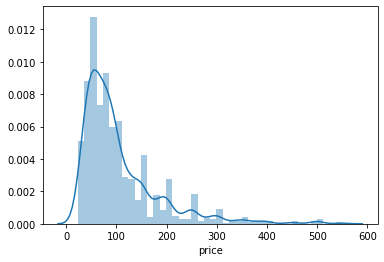

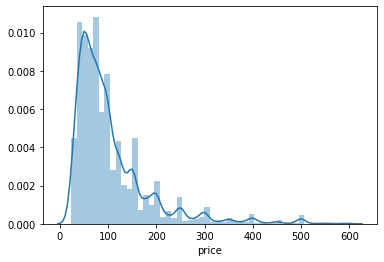

In [1769]:
sns.distplot(y_test)
plt.show()
sns.distplot(y_train)
plt.show()

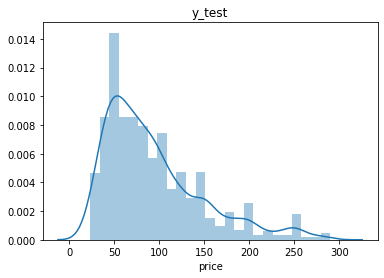

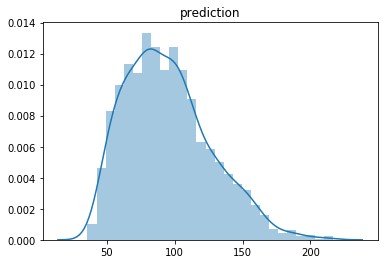

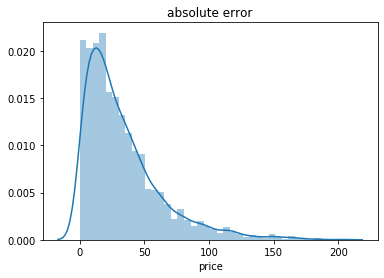

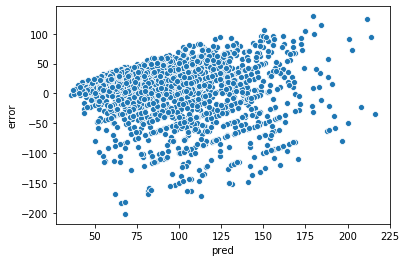

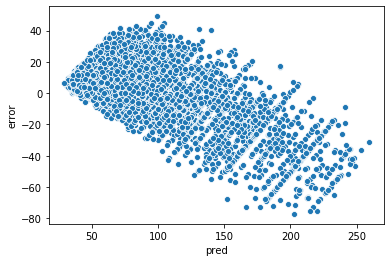

In [368]:
sns.distplot(y_test)
plt.title("y_test")
plt.show()
sns.distplot(rf_y_pred)
plt.title("prediction")
plt.show()
sns.distplot(abs(rf_y_pred-y_test))
plt.title("absolute error")
plt.show()
sns.scatterplot(x=rf_y_pred, y=rf_y_pred-y_test)
plt.xlabel("pred")
plt.ylabel("error")
plt.show()
sns.scatterplot(x=rf_reg.predict(X_train), y=rf_reg.predict(X_train)-y_train)
plt.xlabel("pred")
plt.ylabel("error")
plt.show()

In [2098]:
# First train a dummy regressor as most trivial baseline model -> uses mean price of training data as prediction for all airbnbs in the test dataset
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_y_pred = dummy_regr.predict(X_test)
print("Dummy Regression")
print("R2: {}".format(r2_score(y_test, dummy_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, dummy_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, dummy_y_pred)))


Dummy Regression
R2: -0.0003173761390709018
MAE: 60.94565200805664
MSE: 8749.71484375


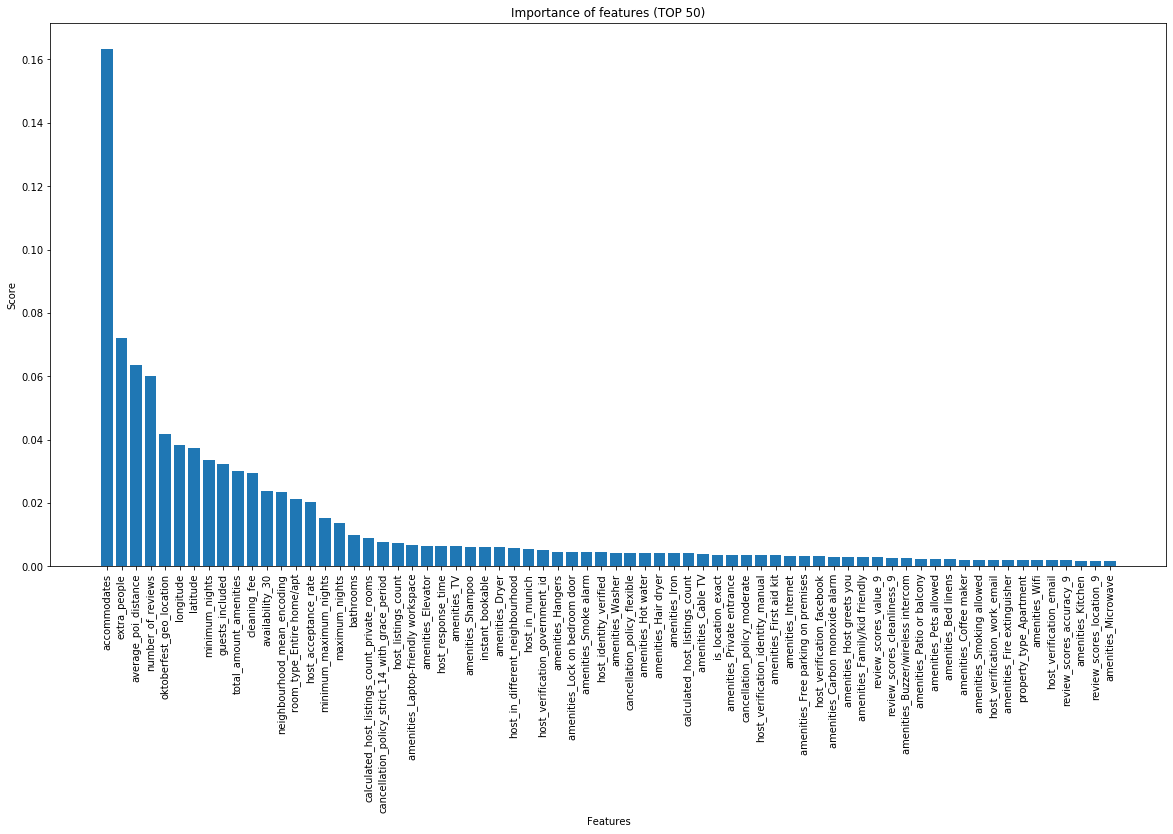

In [1562]:
# Sort the importance of the features
importances = rf_reg.feature_importances_
    
values = sorted(zip(X_train.columns, rf_reg.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature'][:70]
y_feature = np.arange(len(features))
score = feature_importances['score'][:70]

# Plot the importance of a feature to the price
plt.figure(figsize=(20,10));
plt.bar(y_feature, score, align='center');
plt.xticks(y_feature, features, rotation='vertical');
plt.xlabel('Features');
plt.ylabel('Score');
plt.title('Importance of features (TOP 50)');

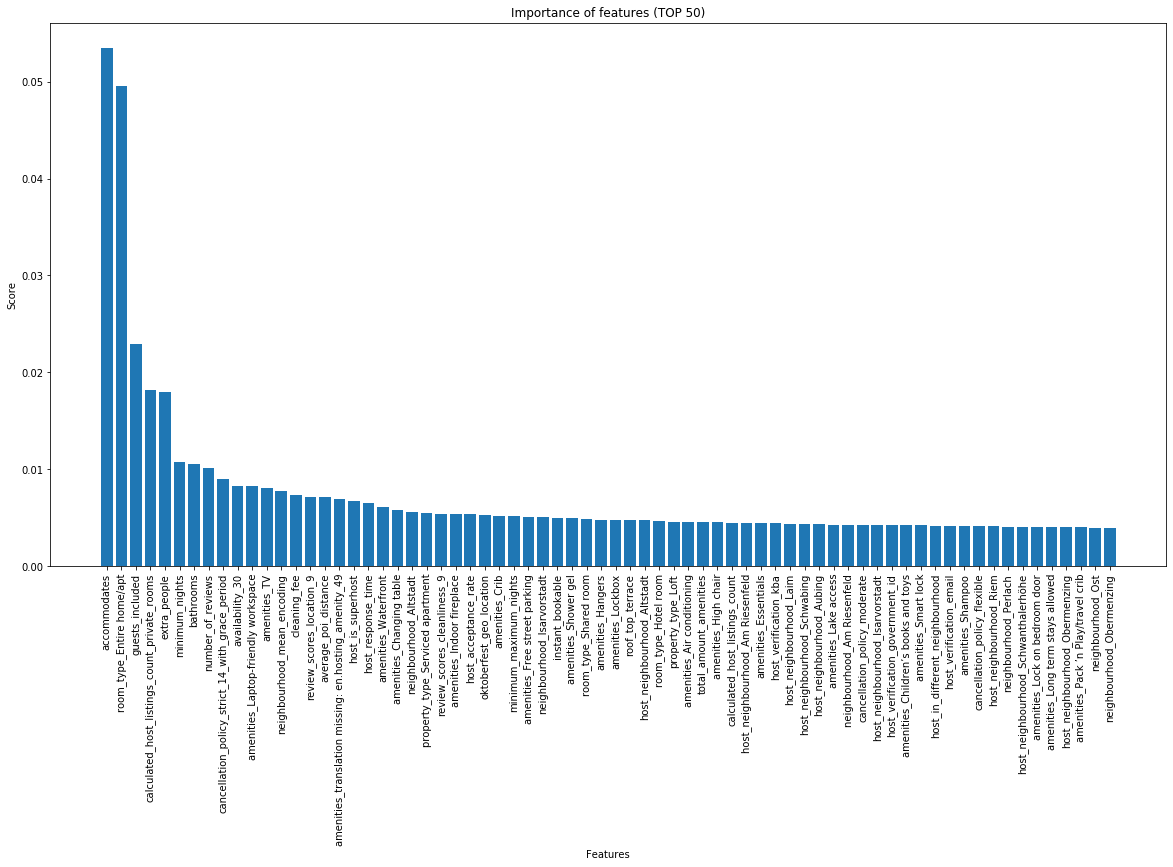

In [1563]:
# Sort the importance of the features
importances = xgb_reg.feature_importances_
    
values = sorted(zip(X_train.columns, xgb_reg.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature'][:70]
y_feature = np.arange(len(features))
score = feature_importances['score'][:70]

# Plot the importance of a feature to the price
plt.figure(figsize=(20,10));
plt.bar(y_feature, score, align='center');
plt.xticks(y_feature, features, rotation='vertical');
plt.xlabel('Features');
plt.ylabel('Score');
plt.title('Importance of features (TOP 50)');

In [371]:
import shap


In [372]:
reg

NameError: name 'reg' is not defined

In [83]:
subset = shuffle(pd.concat([X_train, X_test]))[:100]

In [84]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(subset)


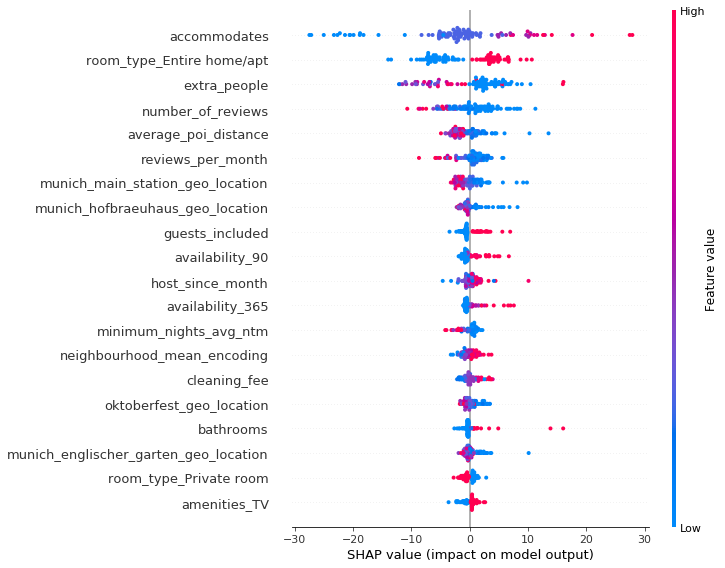

In [85]:
shap.summary_plot(shap_values, subset)

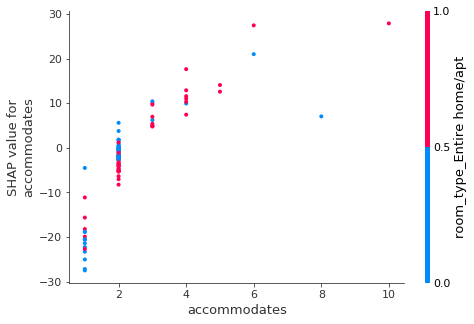

In [86]:
shap.dependence_plot("accommodates", shap_values, subset)

In [91]:
shap.force_plot(shap_va)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [87]:
y_pred = reg.predict(X_train)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_train, y_pred)))
print("MAE: {}".format(mean_absolute_error(y_train, y_pred)))

Random Forest Regression
R2: 0.8945220204069843
MAE: 10.290993689269886
